# Simple DC Power Flow Example
This notebook solves a simple 4-bus DC power flow problem. This example follows pages 19-23 of the notes <a href="https://home.engineering.iastate.edu/~jdm/ee458_2011/PowerFlowEquations.pdf">here</a> but the network is different. Given a bus admittance matrix and nodal power injections, it solves for power flows on each branch of the network.

In [1]:
# load packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
import pandas as pd
import numpy as np

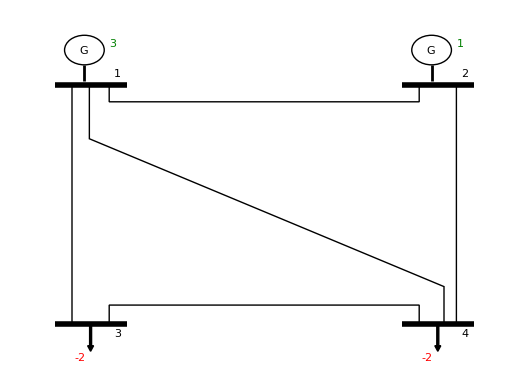

In [2]:
# create diagram of 4-bus network
# function to add generator bus
def add_gen_bus(x,y,axis,n,pu):
    circle = patches.Circle((x,y+.08),0.08,fill=False)
    line = Path([(x,y),(x,y-0.09)],[Path.MOVETO, Path.LINETO])
    line_patch = patches.PathPatch(line,facecolor='black',lw=2)
    bar = Path([(x-0.12,y-0.11),(x+0.17,y-0.11)],[Path.MOVETO, Path.LINETO])
    bar_patch = patches.PathPatch(bar,facecolor='black',lw=4)
    axis.annotate('G',xy=(x-0.02,y+0.06), fontsize=8)
    axis.annotate(n,xy=(x+0.12,y-0.06), fontsize=8)
    axis.annotate(pu,xy=(x+0.1,y+.1), fontsize=8,color='green')
    ps = [circle,line_patch,bar_patch]
    [axis.add_patch(p) for p in ps]
    return
# function to add load bus
def add_load_bus(x,y,axis,n,pu):
    bar = Path([(x-0.12,y),(x+0.17,y)],[Path.MOVETO, Path.LINETO])
    bar_patch = patches.PathPatch(bar,facecolor='black',lw=4)
    arrow = patches.Arrow(x+0.025,y,0,-0.15, width=0.04,color='black')
    axis.annotate(n,xy=(x+0.12,y-0.07), fontsize=8)
    axis.annotate(pu,xy=(x-.04,y-.2), fontsize=8,color='red')
    ps = [bar_patch,arrow]
    [axis.add_patch(p) for p in ps]
    return
# transmission lines 
verts = [(0.4,1.6),(0.4,1.5),(1.65,1.5),(1.65,1.6),
        (1.8,1.6),(1.8,0.3),(1.65,0.3),(1.65,0.4),
        (0.4,0.4),(0.4,0.3), (0.3,0.3),(0.25,0.3),
        (0.25,1.6), (0.32,1.6), (0.32,1.3), (1.75,0.5),
        (1.75,0.3)]
codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO,
         Path.MOVETO, Path.LINETO, Path.MOVETO, Path.LINETO,
         Path.LINETO, Path.LINETO, Path.LINETO, Path.MOVETO,
         Path.LINETO, Path.MOVETO, Path.LINETO, Path.LINETO,
         Path.LINETO]
tx_lines = patches.PathPatch(Path(verts,codes),facecolor='none')
# build figure
fig, ax = plt.subplots()
add_gen_bus(x=0.3,y=1.7,axis=ax,n=1,pu=3)
add_gen_bus(x=1.7,y=1.7,axis=ax,n=2, pu=1)
add_load_bus(x=0.3,y=0.3,axis=ax,n=3,pu=-2)
add_load_bus(x=1.7,y=0.3,axis=ax,n=4,pu=-2)
ax.add_patch(tx_lines)
ax.set_xlim(0,2)
ax.set_ylim(0,2)
ax.axis('off')
plt.show()

In [3]:
# inputs
# input admittances for the tranmission lines
admittances_input = {(1,2):1j*-10,(1,3):1j*-10,(1,4):1j*-10,(2,3):0,(2,4):1j*-10,(3,4):1j*-10}
# power injections at each bus
pwr_inj = np.array([3,1,-2,-2])

## Build the Admittance Matrix

The Y-bus matrix is an 4x4 matrix of bus admittances. The shunt admittances equal zero in this example, so the terms $b_{1}$, $b_{2}$, $b_{3}$, and $b_{4}$ are set to zero.
\begin{equation}
Y = j\begin{bmatrix}
B_{11} & B_{12} & B_{13} & B_{14} \\
B_{21} & B_{22} & B_{23} & B_{24}  \\
B_{31} & B_{32} & B_{33} & B_{34}  \\
B_{14} & B_{24} & B_{34} & B_{44}  \\
\end{bmatrix}
\end{equation}
\begin{equation}
=j\begin{bmatrix}
b_{1}+b_{12}+b_{13}+b_{14} & -b_{12} & -b_{13} & -b_{14} \\
-b_{21} & b_{2}+b_{21}+b_{23}+b_{24} & -b_{23} & -b_{24}  \\
-b_{31} & -b_{32} & b_{3}+b_{31}+b_{32}+b_{34} & -b_{34}  \\
-b_{14} & -b_{24} & -b_{34} & b_{4}+b_{41}+b_{42}+b_{43}  \\
\end{bmatrix}
\end{equation}
\begin{equation}
=j\begin{bmatrix}
-30 & 10 & 10 & 10 \\
10 & -20 & 10 & 0 \\
10 & 10 & -30 & 10  \\
10& 0 & 10 & -20  \\
\end{bmatrix}
\end{equation}

In [4]:
# build the addmittance matrix
Admittance_matrix = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        if i==j: 
            for k in range(len(admittances_input)):
                if (min(i+1,k+1),max(i+1,k+1)) in admittances_input:
                    Admittance_matrix[i,j] += np.imag(admittances_input[(min(i+1,k+1),max(i+1,k+1))])
        else: Admittance_matrix[i,j] = -1*np.imag(admittances_input[(min(i+1,j+1),max(i+1,j+1))])           

## Get the B-prime Matrix

In [5]:
# Multiply the Amittances matrix by -1 (because shunt terms are zero we don't have to subtract them first)
B_matrix = -1*Admittance_matrix
# drop the first row and column- making bus 1 the reference bus
B_prime_matrix = B_matrix[1:,1:]
print(B_prime_matrix)

[[ 20.  -0. -10.]
 [ -0.  20. -10.]
 [-10. -10.  30.]]


## Find the Theta Values

We can use the DC power flow equation
\begin{equation*}
P = B^{'}\theta
\end{equation*}
and rearrange to solve for $\theta$ values of phases angles:
\begin{equation*}
B^{'-1}P = B^{'-1}B^{'}\theta
\end{equation*}
\begin{equation*}
\theta = B^{'-1}P
\end{equation*}

In [6]:
theta = np.matmul(np.linalg.inv(B_prime_matrix),pwr_inj[1:])
theta

array([-0.0125, -0.1625, -0.125 ])

## Solve for Power Flows

Power flow from bus i to bus K can be solved using the Y-bus matrix and the theta values (phase angles):
\begin{equation*}
P_{ik} = B_{ik}(\theta_{i} - \theta_{k})
\end{equation*}

In [7]:
# solve for power flows- values are in p.u.
pwr_flows = {}
for i in admittances_input:
    if i[0]==1:
        pwr_flows[i[0],i[1]] = B_matrix[i[0]-1,i[1]-1]*theta[i[1]-2]  
    else: pwr_flows[i[0],i[1]] = B_matrix[i[0]-1,i[1]-1]*(theta[i[1]-2]-theta[i[0]-2])
print(pwr_flows)

{(1, 2): 0.12500000000000006, (1, 3): 1.625, (1, 4): 1.25, (2, 3): 0.0, (2, 4): 1.125, (3, 4): -0.37500000000000006}


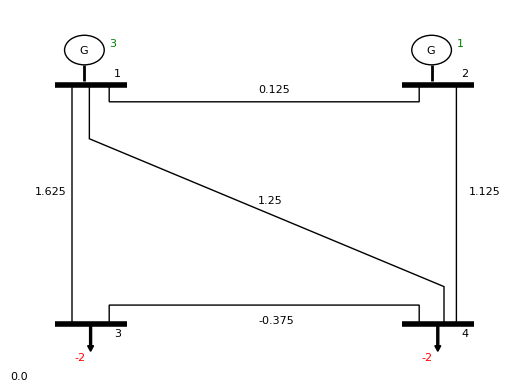

In [8]:
# build figure with power flows
pf_lab_pos = {(1,2):(1,1.55),(1,3):(0.1,1),(1,4):(1,0.95),(2,3):(0,0),(2,4):(1.85,1),(3,4):(1,0.3)}
fig2, ax2 = plt.subplots()
add_gen_bus(x=0.3,y=1.7,axis=ax2,n=1,pu=3)
add_gen_bus(x=1.7,y=1.7,axis=ax2,n=2,pu=1)
add_load_bus(x=0.3,y=0.3,axis=ax2,n=3,pu=-2)
add_load_bus(x=1.7,y=0.3,axis=ax2,n=4,pu=-2)
tx_lines2 = patches.PathPatch(Path(verts,codes),facecolor='none')
for i in pwr_flows:
    ax2.annotate(round(pwr_flows[i],3),xy=pf_lab_pos[i],fontsize=8)
ax2.add_patch(tx_lines2)
ax2.set_xlim(0,2)
ax2.set_ylim(0,2)
ax2.axis('off')
plt.show()
# flows are shown from lowered numbered bus to higher numbered bus
# so 0.125 on the line between buses 1 & 2 means 0.125 is flowing from bus 1 to 2
# and -0.375 on hte line between buses 3 and 4 means 0.375 is flowing from 4 to 3